# Cápitulo 3. Marco Teórico

## Cápitulo 3.1. Teoría de Floquet

En el código posterior se muestra como resolver un hamiltoniano dependiente del tiempo mediante la fórmula 3.8 del trabajo, es decir, resolviendola de forma estrobóscopica usando la teória de Floquet.

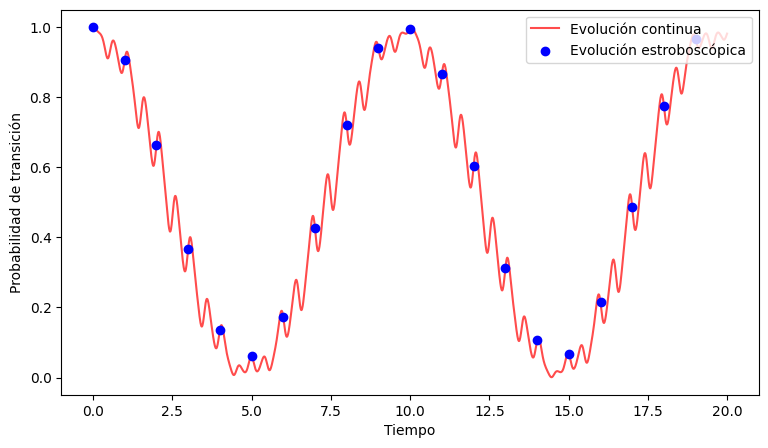

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import os

# Parámetros físicos
hbar = 1.0  # Constante de Planck reducida (normalizada)
Delta = 1   # Acoplamiento
A = 10      # Amplitud del sesgo
T = 1       # Periodo
omega = 2 * np.pi / T  # Frecuencia angular
n = 20  # Número de periodos

# Definir el Hamiltoniano dependiente del tiempo
def Hamiltonian(t, args):
    """Hamiltoniano dependiente del tiempo."""
    epsilon = A * np.cos(omega * t)  # Término oscilante
    return epsilon * sigmaz() + Delta * sigmax() #Hamiltoniano 2D

# Parámetros de la simulación
t_min, t_max, dt = 0, n*T, 0.01   #Definimos la evolución para n periodos
t_values = np.arange(t_min, t_max, dt) 

# Estado inicial |0>
psi0 = basis(2, 0)

# Resolver la evolución continua con mesolve
result = mesolve(Hamiltonian, psi0, t_values, [], []) #Calculamos la evolución continua

# Calcular la probabilidad de estar en el estado |0> con mesolve
P_mesolve = [abs(state[0, 0])**2 for state in result.states]  #Obtenemos la probabilidad de transicioón

# **Evolución estroboscópica**
# Calcular el propagador en un solo período T
t_values_period = np.linspace(0, T, 5000)  # Usamos un solo ciclo
U_list = propagator(Hamiltonian, t_values_period, [])  # Evolución en un único periodo

U_T = U_list[-1]  # Extraemos el propagador en T

# Evaluar en tiempos estroboscópicos (múltiplos de T)
N_cycles = n  # Número de períodos
t_stroboscopic = np.array([n * T for n in range(N_cycles)]) #Cálculamos en tiempos estroboscópicos

# Propagar el estado inicial psi0 usando el propagador en tiempos estroboscópicos
psi_t = psi0
P_stroboscopic = [abs(psi_t[0, 0])**2]  # Probabilidad inicial

for _ in range(1, N_cycles):
    psi_t = U_T * psi_t  # Aplicamos el propagador de un período
    P_stroboscopic.append(abs(psi_t[0, 0])**2)

# **Graficar ambas evoluciones en la misma figura**
plt.figure(figsize=(9, 5))
plt.plot(t_values, P_mesolve, label="Evolución continua", linestyle="-", color="r", alpha=0.7)
plt.scatter(t_stroboscopic, P_stroboscopic, color='b', marker='o', label="Evolución estroboscópica", zorder=3)
plt.ylabel("Probabilidad de transición")
plt.xlabel("Tiempo")
plt.legend(loc='upper right')

# Ruta al escritorio
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "evolucion_comparacion.pdf")
plt.savefig(desktop_path, format='pdf')
plt.show()


## Capítulo 3.2. Puntos cuánticos como sistemas de dos niveles

En este apartado se definen los estados y energías en un donle punto cuántico. Para ilustralo se hacen gráficas mostrando las energías bajo un sesgo lineal, mostrando un resultado fundamental, el cruce evitado:

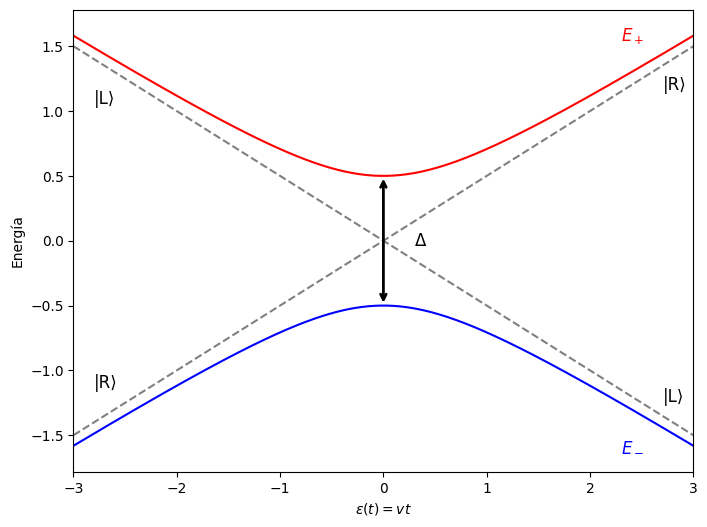

In [139]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Parámetros
Delta = 1  # Distancia mínima entre niveles
v = 1  # Velocidad de barrido del sesgo

t_range = np.linspace(-3, 3, 400)
eps_range = v * t_range

E_d1 = eps_range / 2 #Energías diabáticas
E_d2 = -eps_range / 2  #Energías diabáticas

E_a_plus = 0.5 * np.sqrt(Delta**2 + eps_range**2)  #Energías adiabáticas
E_a_minus = -E_a_plus  #Energías adiabáticas

plt.figure(figsize=(8,6))

plt.plot(eps_range, E_d1, linestyle='--', color='grey')
plt.plot(eps_range, E_d2, linestyle='--', color='grey')
plt.plot(eps_range, E_a_plus, 'r-')
plt.plot(eps_range, E_a_minus, 'b-')

plt.annotate('', xy=(0, Delta/2), xytext=(0, -Delta/2),
             arrowprops=dict(arrowstyle='<->', color='black', lw=2))

plt.text(-2.8, E_d1[1]+0.4, '|R⟩', va='center', ha='left', color='k', fontsize=12)
plt.text(-2.8, E_d2[1]-0.4, '|L⟩', va='center', ha='left', color='k', fontsize=12)

plt.text(2.7, E_d1[-1]-0.3, '|R⟩', va='center', ha='left', color='k', fontsize=12)
plt.text(2.7, E_d2[-1]+0.3, '|L⟩', va='center', ha='left', color='k', fontsize=12)
plt.text(2.3, E_a_plus[-1], '$E_+$', va='center', ha='left', color='r', fontsize=12)
plt.text(2.3, E_a_minus[-1], '$E_-$', va='center', ha='left', color='b', fontsize=12)
plt.text(0.3, 0, 'Δ', va='center', ha='left', color='black', fontsize=12)

plt.xlim(min(eps_range), max(eps_range))  
plt.ylim(min(E_a_minus) - 0.2, max(E_a_plus) + 0.2) 

plt.xlabel(r"$\varepsilon(t) = vt$")
plt.ylabel("Energía")


# Ruta al escritorio
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "estados_tls_sesgo_lineal.pdf")
plt.savefig(desktop_path, format='pdf')
plt.show()


Posteriormente, se hace necesario obtener la probabilidad de transición del estado tras pasar este cruce evitado. Se obtienen ressultados de forma númerica y analítica y se comparan. Para ello, se definen utilizan dos bases diabática y adiabática, ambas en el régimen diabático (estamos modelizando un cruce rápido).

/opt/anaconda3/lib/python3.11/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


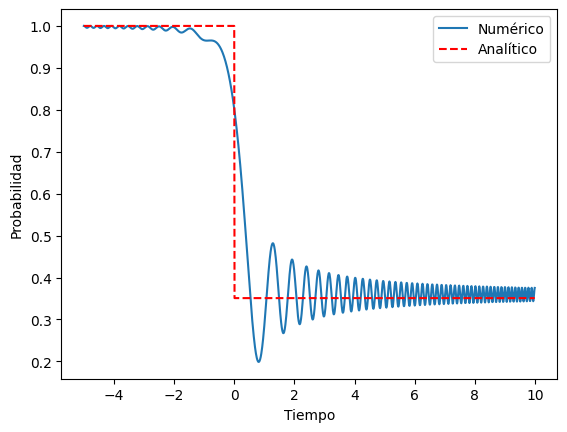

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import Qobj, mesolve

# Physical parameters
hbar = 1.0  # Reduced Planck constant (normalized)
Delta = 1   # Coupling
v = 3       # Bias velocity

def landau_zener_probability(Delta, v, hbar=1):
    """Calculate analytical transition probability using Landau-Zener formula."""
    return np.exp(-np.pi * Delta**2 / (hbar * v))

def hamiltonian(t, args):
    """Define the Hamiltonian matrix in the diabatic basis."""
    v = args['v']
    Delta = args['Delta']
    epsilon = v * t  # Linear bias
    return Qobj([[epsilon, Delta], [Delta, -epsilon]])

def trotter_evolution(t_min, t_max, dt, v, Delta):
    """Evolve the system using QuTiP's mesolve."""
    # Time array
    t_values = np.arange(t_min, t_max, dt)
    
    # Initial state |0> = [1, 0]
    psi0 = Qobj([[1], [0]])
    
    # Arguments for Hamiltonian
    args = {'v': v, 'Delta': Delta}
    
    # Solve Schrödinger equation
    result = mesolve(hamiltonian, psi0, t_values, [], [], args=args)
    
    # Calculate probabilities of being in state |0>
    probabilities = [np.abs(state[0,0])**2 for state in result.states]
    
    return t_values, probabilities

# Simulation parameters
t_min, t_max, dt = -5, 10, 0.01

# Numerical evolution
t_values, P_numerico = trotter_evolution(t_min, t_max, dt, v, Delta)

# Analytical calculation with step function
P_analitico = landau_zener_probability(Delta, v, hbar)
P_analitico_paso = [1 if t < 0 else P_analitico for t in t_values]

# Plot comparison
plt.plot(t_values, P_numerico, label="Numérico", linestyle="-")
plt.plot(t_values, P_analitico_paso, label="Analítico", linestyle="--", color='r')
plt.legend()
plt.ylabel("Probabilidad")
plt.xlabel("Tiempo")

# Ruta al escritorio
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "probabilidad_diabatica_tls_sesgo_lineal.pdf")
plt.savefig(desktop_path, format='pdf')
plt.show()

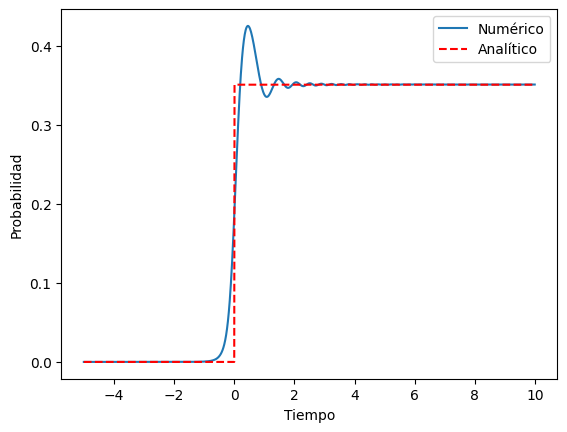

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import Qobj, mesolve, QobjEvo

# Parámetros físicos
hbar = 1.0
Delta = 1
v = 3

# Hamiltoniano
def hamiltonian(t, args):
    v = args['v']
    Delta = args['Delta']
    epsilon = v * t
    return Qobj([[epsilon, Delta], [Delta, -epsilon]])

# Evolución y proyección solo en el estado excitado (adiabático)
def trotter_evolution_adiabatic_excited(t_min, t_max, dt, v, Delta):
    t_values = np.arange(t_min, t_max, dt)
    args = {'v': v, 'Delta': Delta}

    # Hamiltoniano al inicio
    H_ini = hamiltonian(t_min, args)
    evals_ini, evecs_ini = H_ini.eigenstates()
    psi0 = evecs_ini[0]  # Estado adiabático fundamental

    # Índice del otro estado (excitado)
    excited_index = 1

    # Evolución temporal
    H_t = QobjEvo(lambda t, args: hamiltonian(t, args), args=args)
    result = mesolve(H_t, psi0, t_values, c_ops=[], options={"nsteps": 5000})

    # Probabilidad de terminar en el estado adiabático excitado
    P_excitado = []

    for k, t in enumerate(t_values):
        H_tk = hamiltonian(t, args)
        _, evecs = H_tk.eigenstates()
        proj = evecs[excited_index].dag() * result.states[k]
        prob = np.abs(proj)**2
        P_excitado.append(prob)

    return t_values, P_excitado

# Simulación
t_min, t_max, dt = -5, 10, 0.01
t_values, P_numerico = trotter_evolution_adiabatic_excited(t_min, t_max, dt, v, Delta)

# Probabilidad analítica (Landau-Zener)
def landau_zener_probability(Delta, v, hbar=1):
    return np.exp(-np.pi * Delta**2 / (hbar * v))

P_analitico = landau_zener_probability(Delta, v, hbar)
P_analitico_paso = [0 if t < 0 else P_analitico for t in t_values]

# Gráfica
plt.plot(t_values, P_numerico, label="Numérico")
plt.plot(t_values, P_analitico_paso, 'r--', label="Analítico")
plt.legend()
plt.ylabel("Probabilidad")
plt.xlabel("Tiempo")

# Ruta al escritorio
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "probabilidad_adiabatica_tls_sesgo_lineal.pdf")
plt.savefig(desktop_path, format='pdf')
plt.show()


Una vez caracterizada la evolución del sistema bajo un sesgo líneal, se paso a un caso más complejo y relevante para el estudio de la interferometría LZSM, el sesgo oscilatorio. Para ello, primero se hace un análisis pasando el hamiltoniano a un marco rotante, donde se obtienen las condiciones de resonancia que se muestran a continuación.

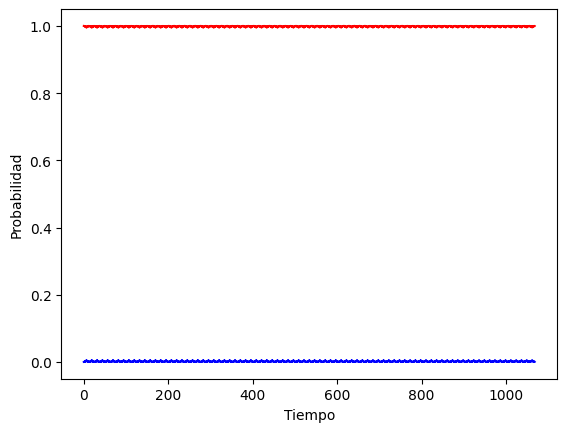

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import os

# Parámetros físicos
hbar = 1.0
Delta = 0.1
A = 10
omega = 1
epsilon0 = 1.5
T = 2 * np.pi / omega

# Definir el Hamiltoniano (con factor 1/2)
def Hamiltonian(t, args):
    """Hamiltoniano dependiente del tiempo."""
    epsilon = epsilon0 + A * np.cos(omega * t)
    return 0.5 * (epsilon * sigmaz() + Delta * sigmax())

# Parámetros de la simulación
t_min, t_max, dt = 0, 170*T, 0.01
t_values = np.arange(t_min, t_max, dt)

# Estado inicial |0>
psi0 = basis(2, 0)

# Resolver la evolución temporal
result = mesolve(Hamiltonian, psi0, t_values, [], [])

# Calcular probabilidades
P_transition = [expect(basis(2,1) * basis(2,1).dag(), state) for state in result.states]
P_stay = [expect(basis(2,0) * basis(2,0).dag(), state) for state in result.states]

# Graficar
plt.plot(t_values, P_transition, linestyle="-", color="blue")
plt.plot(t_values, P_stay, linestyle="-", color="red")

plt.ylim(-0.05, 1.05)
plt.ylabel("Probabilidad")
plt.xlabel("Tiempo")

# Ruta al escritorio
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "probabilidad_no_resonante.pdf")
plt.savefig(desktop_path, format='pdf')
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


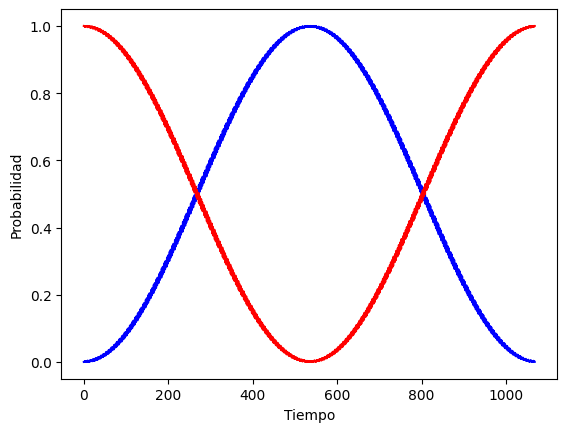

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import os

# Parámetros físicos
hbar = 1.0
Delta = 0.1
A = 10
omega = 1
epsilon0 = 3
T = 2 * np.pi / omega

# Definir el Hamiltoniano (con factor 1/2)
def Hamiltonian(t, args):
    """Hamiltoniano dependiente del tiempo."""
    epsilon = epsilon0 + A * np.cos(omega * t)
    return 0.5 * (epsilon * sigmaz() + Delta * sigmax())

# Parámetros de la simulación
t_min, t_max, dt = 0, 170*T, 0.01
t_values = np.arange(t_min, t_max, dt)

# Estado inicial |0>
psi0 = basis(2, 0)

# Resolver la evolución temporal
result = mesolve(Hamiltonian, psi0, t_values, [], [])

# Calcular probabilidades
P_transition = [expect(basis(2,1) * basis(2,1).dag(), state) for state in result.states]
P_stay = [expect(basis(2,0) * basis(2,0).dag(), state) for state in result.states]

# Graficar
plt.plot(t_values, P_transition, linestyle="-", color="blue")
plt.plot(t_values, P_stay, linestyle="-", color="red")

plt.ylim(-0.05, 1.05)
plt.ylabel("Probabilidad")
plt.xlabel("Tiempo")

# Ruta al escritorio
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "probabilidad_resonante.pdf")
plt.savefig(desktop_path, format='pdf')
plt.show()

## Capítulo 3.3 Diagramas de interferencia LZSM

El cambio al marco rotante es útil para caracterizar de forma efetciva el sistema. Sin embargo, en casos donde no sea posible aplicarlo como en un régimen adiabático, o si necesitamos tener una comprensión más profunda del sistema, será necesario definir una herramienta que nos permita caracterizar de forma completa su evolución de forma análitica. En este marco, surge el método AIM, para comprender en que se basa, primero debemos entender como han cambiado las energías al añadir el sesgo oscilatorio. Para ello, se muestra el siguiente gráfico.

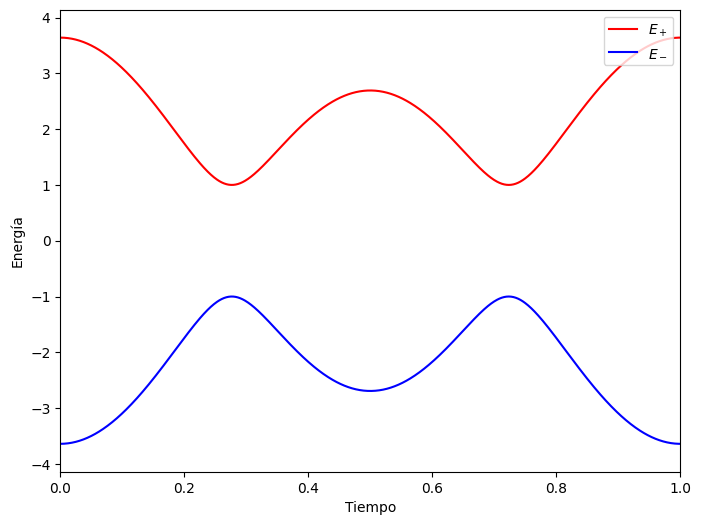

In [127]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import Qobj
import os

# Parámetros
hbar = 1.0
Delta = 1          # Brecha energética mínima entre niveles
epsilon_0 = 0.5      # Sesgo estático (promedio)
A = 3              # Amplitud de la oscilación
omega = 2 * np.pi  # Frecuencia angular de la oscilación
T = 2*np.pi/omega

# Rango temporal
t_range = np.linspace(0, T, 800)

# Definir Hamiltoniano instantáneo
def hamiltonian(t, args):
    epsilon_0 = args['epsilon_0']
    A = args['A']
    omega = args['omega']
    Delta = args['Delta']
    epsilon = epsilon_0 + A * np.cos(omega * t)
    return Qobj([[epsilon, Delta], [Delta, -epsilon]])

# Parámetros para el Hamiltoniano
args = {'epsilon_0': epsilon_0, 'A': A, 'omega': omega, 'Delta': Delta}

# Calcular autoenergías en cada instante
evals_plus = []
evals_minus = []

for t in t_range:
    H_t = hamiltonian(t, args)
    evals = H_t.eigenenergies()
    evals_plus.append(evals[1])  # Estado de mayor energía
    evals_minus.append(evals[0]) # Estado de menor energía

# Gráfica
plt.figure(figsize=(8, 6))

# Autoenergías (líneas continuas)
plt.plot(t_range, evals_plus, 'r-', label='$E_+$')
plt.plot(t_range, evals_minus, 'b-', label='$E_-$')

# Ajustar límites
plt.xlim(min(t_range), max(t_range))
plt.ylim(min(evals_minus) - 0.5, max(evals_plus) + 0.5)

# Etiquetas de ejes
plt.xlabel(r"Tiempo")
plt.ylabel("Energía")

plt.legend(loc="upper right")

# Ruta al escritorio
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "Energias_oscilatorio_2D.pdf")
plt.savefig(desktop_path, format='pdf')
plt.show()

En el gráfico, se comprueba que ahora hay dos cruces evitados. Entonces, el método AIM se basa en definir la evolución fuera de los cruces como puramente adiabático y considerar el cruce como un impulso puntual. Siguiendo el desarrollo analítico se obtiene una forma obtener la evolcuión de la probabilidad en tiempos estroboscópicos tras haber atravesado los cruces evitados n veces, la fórmula 3.55. Para demostrar su validez, se compara con la evolución anaálitica del sistema, mostrando un gran acuerdo.

/opt/anaconda3/lib/python3.11/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


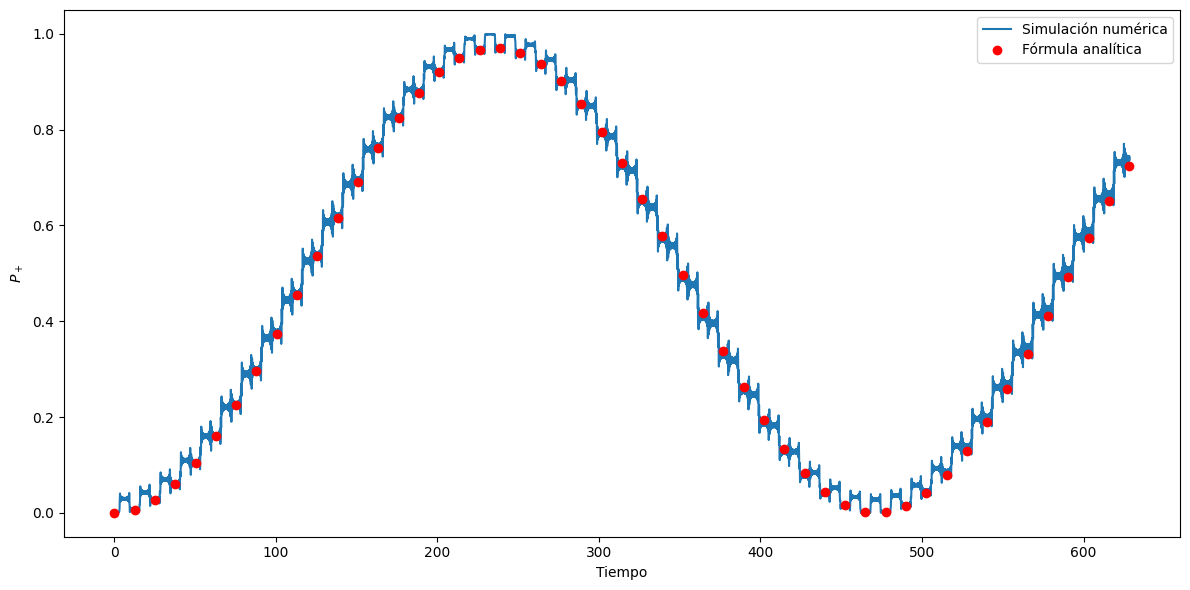

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from scipy.special import gamma
from cmath import phase
from scipy.integrate import quad

# Parámetros físicos
hbar = 1.0
Delta = 1.0
A = 100.0
omega = 0.5
T = 2 * np.pi / omega

# Función de bias
def epsilon(t):
    return A * np.cos(omega * t)

# Probabilidad de LZ
v = A * omega
delta = Delta**2 / (4 * hbar * v)
P = np.exp(-2 * np.pi * delta)

# Fase de Stokes
phi_S = (np.pi / 4) + delta * (np.log(delta) - 1) + phase(gamma(1 - 1j * delta))

# Fase dinámica
def DeltaE(t):
    return np.sqrt(Delta**2 + epsilon(t)**2)

t1 = np.pi / (2 * omega)
t2 = 3 * np.pi / (2 * omega)
zeta, _ = quad(lambda t: DeltaE(t)/(2*hbar), t1, t2)

# Fase total
Phi_St = phi_S + zeta
phi = np.arccos(- (1 - P) * np.cos(2*zeta + 2*phi_S) - P)

# Tiempo continuo para simulación
t_min, t_max, dt = 0, 50 * T, 0.01
t_values = np.arange(t_min, t_max, dt)

# Tiempo estroboscópico para la fórmula analítica
n_array = np.arange(0, int(t_max // T) + 1)
t_estroboscopico = n_array * T

# Fórmula analítica estroboscópica
P_double = 4 * P * (1 - P) * (np.sin(Phi_St)**2)
P_analitica = P_double * (np.sin(n_array * phi)**2) / (np.sin(phi)**2)

# Simulación numérica continua
psi0 = basis(2, 0)
def Hamiltonian(t, args):
    return -0.5 * (Delta * sigmax() + epsilon(t) * sigmaz())

result = sesolve(Hamiltonian, psi0, t_values, [sigmaz()])
P_numerica = (1 - result.expect[0]) / 2

# Gráfica
plt.figure(figsize=(12, 6))
plt.plot(t_values, P_numerica, label="Simulación numérica")
plt.plot(t_estroboscopico, P_analitica, 'ro', label="Fórmula analítica")  # Puntos sin unir
plt.xlabel("Tiempo")
plt.ylabel("$P_+$")
plt.legend()

plt.tight_layout()

# Ruta al escritorio
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "Probabilidad_transición_analítica_2D.pdf")
plt.savefig(desktop_path, format='pdf')
plt.show()

Entonces se ha podido caracterizar la evolución completa del cruce. Sin embargo, no es posible medir la evolución continua. Por ello, es necesario obtener un observable real, es decir, el valor esperado del sistema. Un avez obtenida la fórmula para la probabilidad media, se puede utilizar para obtener los diagramas LZSM. En estos diagramas de interferencía se varian los parametros de control del experimento para obtener las condiciones de resonancia del sistema y así caracterizarlo. Usanso el sesgo inicial y la amplitud como parámetros de control, gráficamos las diagramas de interferencía tanto de forma análitica como númerica.

Empezaremos con los diagramas en el régimen diabático.

Calculando probabilidad de transición: 100%|██████████| 90000/90000 [00:14<00:00, 6183.38it/s]


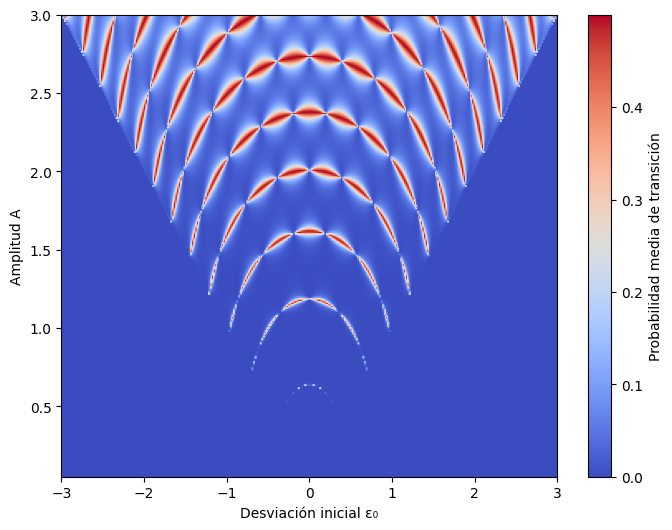

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from multiprocess import Pool
from scipy.integrate import quad
from scipy.special import gamma
import os  # Asegúrate de importar os para guardar el archivo

# Parámetros físicos globales
hbar = 1.0
Delta = 1
omega = 0.2
T = 2 * np.pi / omega

# Definir la función de energía instantánea Ω(t)
def Omega(t, epsilon_0, A):
    epsilon_t = epsilon_0 - A * np.cos(omega * t)
    return np.sqrt(Delta**2 + epsilon_t**2)

# Integración numérica de ζ1 y ζ2 con manejo de valores inválidos
def compute_zeta(epsilon_0, A):
    if abs(epsilon_0 / A) > 1:
        return None, None  # No hay cruces, evitar cálculos
    
    phi = np.arccos(epsilon_0 / A)
    t1 = (phi) / omega
    t2 = (2*np.pi - phi) / omega

    zeta1, _ = quad(Omega, t1, t2, args=(epsilon_0, A))
    zeta2, _ = quad(Omega, t2, t1 + 2 * np.pi / omega, args=(epsilon_0, A))

    return zeta1 / 2, zeta2 / 2

# Stokes phase
def stokes_phase(delta):
    return -np.pi/2 + delta * (np.log(delta) - 1) + np.angle(gamma(1 - 1j * delta))

# Función para calcular P_mean con la ecuación (38)
def calculate_P_mean(params):
    i, A, j, epsilon_0 = params

    # Si no hay cruces, la probabilidad es 0
    if abs(epsilon_0 / A) > 1:
        return i, j, 0.0

    # Calcular los valores
    delta = Delta**2 / (4*A * omega)
    P_LZ = np.exp(-2 * np.pi * delta)
    zeta1, zeta2 = compute_zeta(epsilon_0, A)

    # Si no hay valores válidos de zeta, retornamos P = 0
    if zeta1 is None or zeta2 is None:
        return i, j, 0.0

    phi_S = stokes_phase(delta)

    # Calcular ζ+ y ζ-
    zeta_plus = zeta1 + zeta2 + 2 * phi_S
    zeta_minus = zeta1 - zeta2

    # Cálculo de P_mean basado en la ecuación (38)
    num = P_LZ * (1 + np.cos(zeta_plus) * np.cos(zeta_minus))
    denom = np.sin(zeta_plus)**2 + 2 * P_LZ * (1 + np.cos(zeta_plus) * np.cos(zeta_minus))
    P_mean = num / denom 

    return i, j, P_mean

# Parámetros ajustados para los nuevos ejes
epsilon_0_values = np.linspace(-3 * omega, 3 * omega, 300) / omega
A_values = np.linspace(0.01, 3 * omega, 300) / omega  # Evitar A = 0

# Crear matriz de resultados
P_mean_matrix = np.zeros((len(A_values), len(epsilon_0_values)))

# Preparar parámetros para paralelización
params = [(i, A, j, epsilon_0) 
          for i, A in enumerate(A_values) 
          for j, epsilon_0 in enumerate(epsilon_0_values)]

# Calcular en paralelo con barra de progreso
with Pool() as pool:
    results = list(tqdm(pool.imap(calculate_P_mean, params), 
                        total=len(params), 
                        desc="Calculando probabilidad de transición"))

# Rellenar matriz con resultados
for i, j, p_mean in results:
    P_mean_matrix[i, j] = p_mean

# Crear mapa de calor sin máscara
plt.figure(figsize=(8, 6))
cmap = plt.cm.coolwarm

plt.imshow(P_mean_matrix, extent=[epsilon_0_values[0], epsilon_0_values[-1], 
                                  A_values[0], A_values[-1]], 
           origin="lower", aspect="auto", cmap=cmap)
plt.colorbar(label="Probabilidad media de transición")
plt.xlabel("Desviación inicial ε₀")
plt.ylabel("Amplitud A")

# Ruta al escritorio
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "Diagrama_LZSM_analitico_2D.pdf")
plt.savefig(desktop_path, format='pdf')
plt.show()



Calculando evolución adiabática: 100%|██████████| 90000/90000 [21:32<00:00, 69.61it/s]  


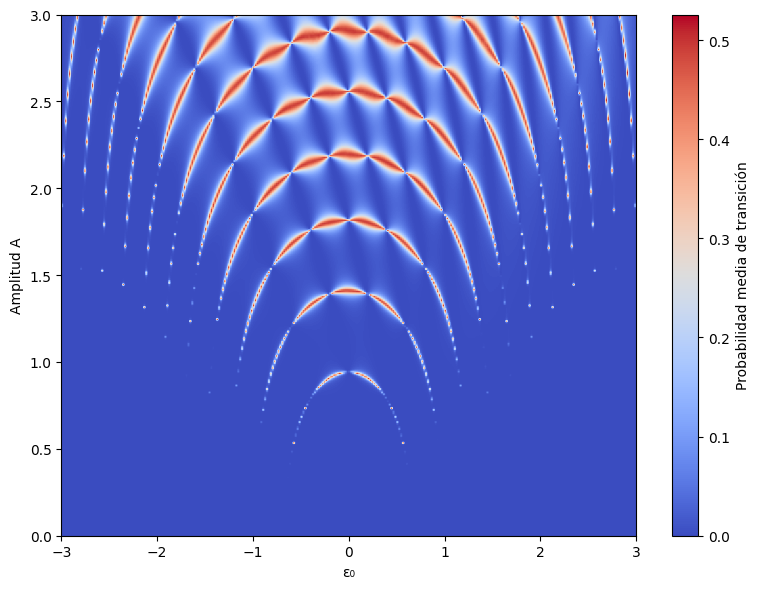

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from tqdm import tqdm
from multiprocess import Pool

# Parámetros físicos
hbar = 1.0
Delta = 1
omega = 0.2
T = 2 * np.pi / omega
n = 1000

# Hamiltoniano dependiente del tiempo
def Hamiltonian(t, args):
    epsilon_0 = args["epsilon_0"]
    A = args["A"]
    epsilon = epsilon_0 - A * np.cos(omega * t)
    return (epsilon / 2) * sigmaz() + (Delta / 2) * sigmax()

# Función que devuelve los autovectores adiabáticos en el tiempo t
def get_adiabatic_states(t, args):
    H_t = Hamiltonian(t, args)
    evals, evecs = H_t.eigenstates()
    # Ordenamos: E_- (ground), E_+ (excited)
    return evecs[0], evecs[1]  # |E_-(t)>, |E_+(t)>

# Calcular P_mean adiabático
def calculate_P_mean_adiabatic(params):
    i, A, j, epsilon_0, t_values_period = params
    args = {"epsilon_0": epsilon_0, "A": A}

    # Estado inicial: estado adiabático fundamental en t = 0
    psi0 = get_adiabatic_states(t_values_period[0], args)[0]

    # Propagador un ciclo
    U_list = propagator(Hamiltonian, t_values_period, [], args=args)
    U_T = U_list[-1]

    psi_t = psi0
    P_stroboscopic = np.zeros(n)

    for k in range(n):
        t_k = t_values_period[0]  # t=0 siempre porque usamos evolución estroboscópica
        _, excited_state = get_adiabatic_states(t_k, args)
        P_stroboscopic[k] = abs((excited_state.dag() * psi_t))**2
        psi_t = U_T * psi_t  # Evolución estroboscópica

    return i, j, np.mean(P_stroboscopic)

# Rango de parámetros
epsilon_0_values = np.linspace(-3, 3, 300)
A_values = np.linspace(0, 3, 300)
t_values_period = np.linspace(0, T, 1000)

# Matriz resultado
P_mean_matrix = np.zeros((len(A_values), len(epsilon_0_values)))

# Parámetros para paralelo
params = [(i, A, j, epsilon_0, t_values_period)
          for i, A in enumerate(A_values)
          for j, epsilon_0 in enumerate(epsilon_0_values)]

# Ejecución paralela
with Pool() as pool:
    results = list(tqdm(pool.imap(calculate_P_mean_adiabatic, params),
                        total=len(params),
                        desc="Calculando evolución adiabática"))

# Cargar resultados
for i, j, p_mean in results:
    P_mean_matrix[i, j] = p_mean

# Graficar
plt.figure(figsize=(8, 6))
plt.imshow(P_mean_matrix, extent=[epsilon_0_values[0], epsilon_0_values[-1],
                                  A_values[0], A_values[-1]],
           origin="lower", aspect="auto", cmap="coolwarm")
plt.colorbar(label="Probabilidad media de transición")
plt.xlabel("ε₀")
plt.ylabel("Amplitud A")
plt.tight_layout()

# Ruta al escritorio
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "Diagrama_LZSM_adiabático_númerico_2D.pdf")
plt.savefig(desktop_path, format='pdf')
plt.show()

Se puede ver que ambos diagramas presentan una gran concordancía. Un factor clave que podemos observar aquí, es la gran ventaja computacional que presenta el modelo AIM frente a la evolución númerica.

Ahora se realizan los diagramás para el régimen diabático

Calculando P_up (versión cos²): 100%|██████████| 90000/90000 [00:19<00:00, 4581.79it/s]


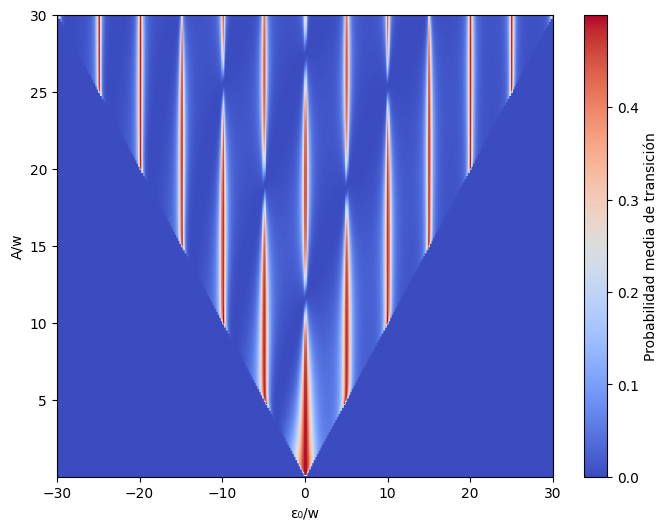

In [134]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from multiprocess import Pool
from scipy.integrate import quad
import os

# Parámetros físicos
hbar = 1.0
Delta = 1.0
omega = 5
T = 2 * np.pi / omega

# Definición de Ω(t)
def Omega(t, epsilon_0, A):
    epsilon_t = epsilon_0 - A * np.cos(omega * t)
    return np.sqrt(Delta**2 + epsilon_t**2)

# Cálculo de zeta1 y zeta2
def compute_zeta(epsilon_0, A):
    if abs(epsilon_0 / A) > 1:
        return None, None
    
    phi = np.arccos(epsilon_0 / A)
    t1 = (phi) / omega
    t2 = (2*np.pi - phi) / omega

    zeta1, _ = quad(Omega, t1, t2, args=(epsilon_0, A))
    zeta2, _ = quad(Omega, t2, t1 + T, args=(epsilon_0, A))

    return zeta1 / 2, zeta2 / 2

# Nueva fórmula basada en P_up con cos^2
def calculate_P_up(params):
    i, A, j, epsilon_0 = params

    if abs(epsilon_0 / A) > 1:
        return i, j, 0.0

    zeta1, zeta2 = compute_zeta(epsilon_0, A)
    if zeta1 is None or zeta2 is None:
        return i, j, 0.0

    delta = Delta**2 / (4 * A * omega)
    zeta_minus = zeta1 - zeta2

    cos_term = np.cos(zeta2 - np.pi / 4)**2
    numerator = 4 * np.pi * delta * cos_term
    denominator = np.sin(zeta_minus)**2 + numerator

    P_up = 0.5 * numerator / denominator
    return i, j, P_up

# Rango de parámetros
epsilon_0_values = np.linspace(-30 * omega, 30 * omega, 300) / omega
A_values = np.linspace(0.01, 30 * omega, 300) / omega

# Inicializar matriz de resultados
P_matrix = np.zeros((len(A_values), len(epsilon_0_values)))

# Crear lista de parámetros para paralelización
params = [(i, A, j, epsilon_0)
          for i, A in enumerate(A_values)
          for j, epsilon_0 in enumerate(epsilon_0_values)]

# Cálculo en paralelo con barra de progreso
with Pool() as pool:
    results = list(tqdm(pool.imap(calculate_P_up, params),
                        total=len(params),
                        desc="Calculando P_up (versión cos²)"))

# Rellenar matriz
for i, j, p in results:
    P_matrix[i, j] = p

# Visualización
plt.figure(figsize=(8, 6))
plt.imshow(P_matrix, extent=[epsilon_0_values[0], epsilon_0_values[-1],
                             A_values[0], A_values[-1]],
           origin='lower', aspect='auto', cmap='coolwarm')
plt.colorbar(label="Probabilidad media de transición")
plt.xlabel("ε₀/w")
plt.ylabel("A/w")

# Guardar imagen
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "Diagrama_LZSM_diabático_analitico_2D.pdf")
plt.savefig(desktop_path, format='pdf')
plt.show()


Calculando evolución estroboscópica: 100%|██████████| 90000/90000 [03:58<00:00, 376.87it/s]


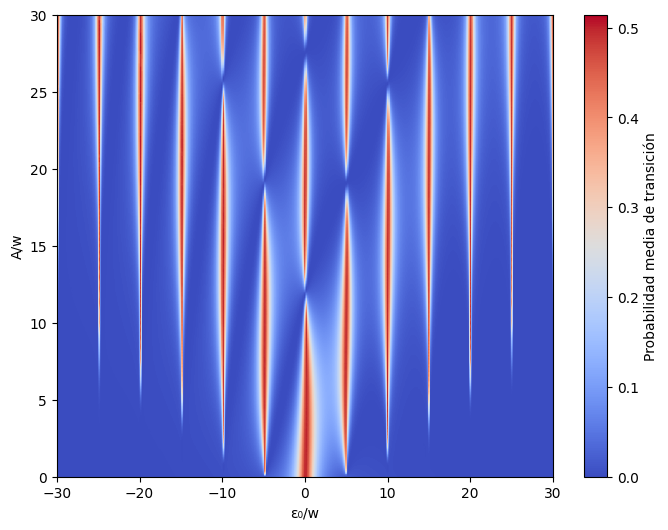

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from tqdm import tqdm
from multiprocess import Pool

# Parámetros físicos globales
hbar = 1.0
Delta = 1
omega = 5
T = 2 * np.pi / omega
n = 1000

# Hamiltoniano dependiente del tiempo
def Hamiltonian(t, args):
    epsilon_0 = args["epsilon_0"]
    A = args["A"]
    epsilon = epsilon_0 + A * np.cos(omega * t)
    return 0.5*(epsilon * sigmaz() + Delta * sigmax())

# Función para calcular P_mean para un par (A, epsilon_0)
def calculate_P_mean(params):
    i, A, j, epsilon_0, t_values_period, psi0 = params
    args = {"epsilon_0": epsilon_0, "A": A}
    
    U_list = propagator(Hamiltonian, t_values_period, [], args=args)
    U_T = U_list[-1]
    
    psi_t = psi0
    P_stroboscopic = np.zeros(n)
    P_stroboscopic[0] = abs(psi_t[1, 0])**2
    
    for k in range(1, n):
        psi_t = U_T * psi_t
        P_stroboscopic[k] = abs(psi_t[1, 0])**2
    
    return i, j, np.mean(P_stroboscopic)

# Parámetros ajustados para los nuevos ejes
epsilon_0_values = np.linspace(-30*omega, 30*omega, 300)/omega  # Normalizado por omega
A_values = np.linspace(0, 30*omega, 300)/omega  # Normalizado por omega
t_values_period = np.linspace(0, T, 1000)
psi0 = basis(2, 0)

# Crear matriz de resultados
P_mean_matrix = np.zeros((len(A_values), len(epsilon_0_values)))

# Preparar parámetros para paralelización
params = [(i, A, j, epsilon_0, t_values_period, psi0) 
          for i, A in enumerate(A_values) 
          for j, epsilon_0 in enumerate(epsilon_0_values)]

# Calcular en paralelo con barra de progreso
with Pool() as pool:
    results = list(tqdm(pool.imap(calculate_P_mean, params), 
                       total=len(params), 
                       desc="Calculando evolución estroboscópica"))

# Rellenar matriz con resultados
for i, j, p_mean in results:
    P_mean_matrix[i, j] = p_mean

# Crear mapa de calor
plt.figure(figsize=(8, 6))
plt.imshow(P_mean_matrix, extent=[epsilon_0_values[0], epsilon_0_values[-1], 
                                  A_values[0], A_values[-1]], 
           origin="lower", aspect="auto", cmap="coolwarm")
plt.colorbar(label="Probabilidad media de transición")
plt.xlabel("ε₀/w")
plt.ylabel("A/w")

# Guardar imagen
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "Diagrama_LZSM_diabático_númerico_2D.pdf")
plt.savefig(desktop_path, format='pdf')
plt.show()


Como podemos ver ambos diagramas también presentan una alta concordancía. Es importante remarcar que el rango de validez del modelo AIM es $\epsilon_0 < A$, puesto que debe haber cruces evitados. En los diagramás númericos encontramos probabilidad en esta zona porque sigue habiendo una probabilidad no nula de transición (Debido a $\Delta$ principalmente)

En el trabajo queda explicado en mayor medida que propósito cumplen estos diagramas. En resumen, los puntos de alta probabilidad corresponden a resonancias, la nitidez del patrón se corresponde con la coherencía del qubit y puede ser una herramienta para el estudio de decoherencia. Además se usa en control y caracterización de qubits.

# Cápitulo 5. Resultados

## Cápitulo 5.1. Estados y energías en un DQD en Si/SiGe

En este cápitulo se hace un procedimiento similar al seguido en el anterior, pero en este caso se utilizara para caracterizar un sistema de cuatro niveles, de un doble punto cuántico. El hamiltoniano y energías de este han sido obtenido en el trabajo. Aquí se muestra una gráfica con las energías para un sesgo líneal y oscilatorio.

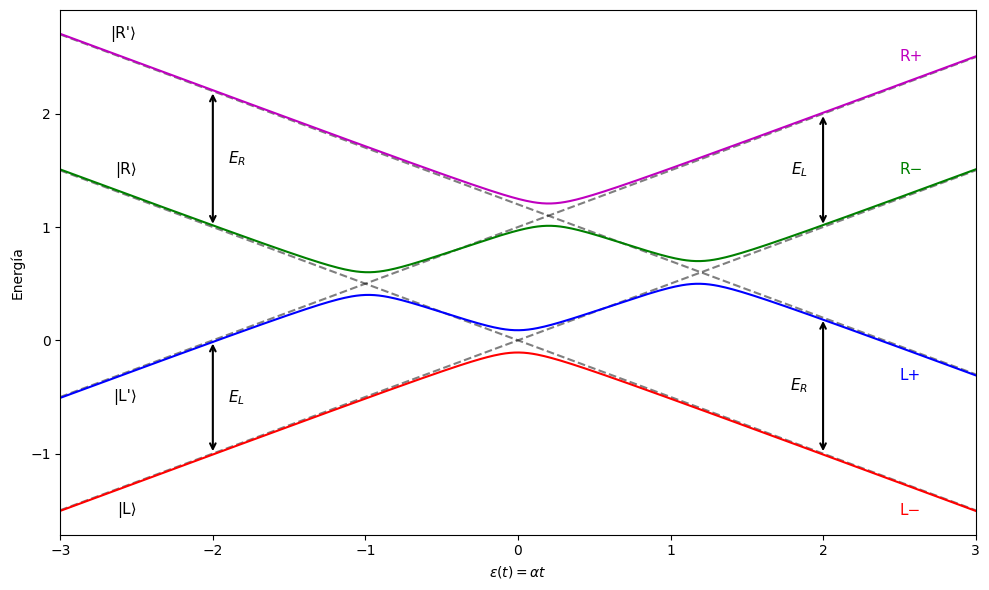

In [331]:
import os
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# ===========================
# Parámetros físicos
# ===========================
alpha = 1      # velocidad del barrido
t_max = 3      # tiempo total
n_points = 400 # resolución temporal

# ===========================
# Hamiltoniano 4D
# ===========================
EL = 1
ER = 1.2
tc = 0.1
tpc = 0.1

def Hamiltonian(t):
    epsilon = alpha * t
    return Qobj(np.array([
        [epsilon / 2 + EL, 0, tc, tpc],
        [0, epsilon / 2, -tpc, tc],
        [tc, -tpc, -epsilon / 2 + ER, 0],
        [tpc, tc, 0, -epsilon / 2]
    ]))

# ===========================
# Rango temporal
# ===========================
t_list = np.linspace(-t_max, t_max, n_points)
eps_list = alpha * t_list

# ===========================
# Cálculo de energías
# ===========================
adiabatic_energies = np.zeros((4, n_points))
diabatic_energies = np.zeros((4, n_points))

for i, t in enumerate(t_list):
    H_t = Hamiltonian(t)
    evals, evecs = H_t.eigenstates()
    adiabatic_energies[:, i] = np.real(evals)
    diabatic_energies[:, i] = np.real(np.diag(H_t.full()))

# ===========================
# Función para dibujar flechas y etiquetas
# ===========================
def draw_arrows_and_labels(epsilon0, diab_energies, eps_list, label_side='left', text_offset=0.1):
    # Encontrar índice más cercano a epsilon0
    idx = np.argmin(np.abs(eps_list - epsilon0))
    energies = diab_energies[:, idx]
    
    # Identificar niveles
    L_lower, L_upper = energies[0], energies[1]  # |L⟩, |L'⟩
    R_lower, R_upper = energies[2], energies[3]  # |R⟩, |R'⟩
    
    # Configuración de etiquetas
    ha = label_side
    offset = text_offset if label_side == 'left' else -text_offset
    
    # Flecha y etiqueta para EL
    plt.annotate('', xy=(epsilon0, L_upper), xytext=(epsilon0, L_lower),
                 arrowprops=dict(arrowstyle='<->', color='black', lw=1.5))
    plt.text(epsilon0 + offset, (L_lower + L_upper) / 2, '$E_L$', va='center', ha=ha, fontsize=11)
    
    # Flecha y etiqueta para ER
    plt.annotate('', xy=(epsilon0, R_upper), xytext=(epsilon0, R_lower),
                 arrowprops=dict(arrowstyle='<->', color='black', lw=1.5))
    plt.text(epsilon0 + offset, (R_lower + R_upper) / 2, '$E_R$', va='center', ha=ha, fontsize=11)

# ===========================
# Gráfica
# ===========================
plt.figure(figsize=(10, 6))

# Etiquetas
diabatic_labels = ["|L'⟩", "|L⟩", "|R'⟩", "|R⟩"]
adiabatic_labels = ["L−", "L+", "R−", "R+"]

# Diabáticos
for i in range(4):
    plt.plot(eps_list, diabatic_energies[i], 'k--', alpha=0.5)
    plt.text(eps_list[0] + 0.5, diabatic_energies[i][0], diabatic_labels[i],
             va='center', ha='right', fontsize=11, color='k')

# Adiabáticos
colors = ['r', 'b', 'g', 'm']
for i in range(4):
    plt.plot(eps_list, adiabatic_energies[i], '-', color=colors[i])
    plt.text(eps_list[-1] - 0.5, adiabatic_energies[i][-1], adiabatic_labels[i],
             va='center', ha='left', fontsize=11, color=colors[i])

# ===========================
# Dibujar flechas
# ===========================
draw_arrows_and_labels(epsilon0=-2, diab_energies=diabatic_energies, eps_list=eps_list, label_side='left', text_offset=0.1)
draw_arrows_and_labels(epsilon0=2, diab_energies=diabatic_energies, eps_list=eps_list, label_side='right', text_offset=0.1)

# ===========================
# Ejes y título
# ===========================
plt.xlabel(r"$\varepsilon(t) = \alpha t$")
plt.ylabel("Energía")
plt.xlim(eps_list[0], eps_list[-1])
plt.tight_layout()

# ===========================
# Guardar imagen
# ===========================
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "Energias_4D_lineal_asímetrico.pdf")
plt.savefig(desktop_path, format='pdf')
plt.show()

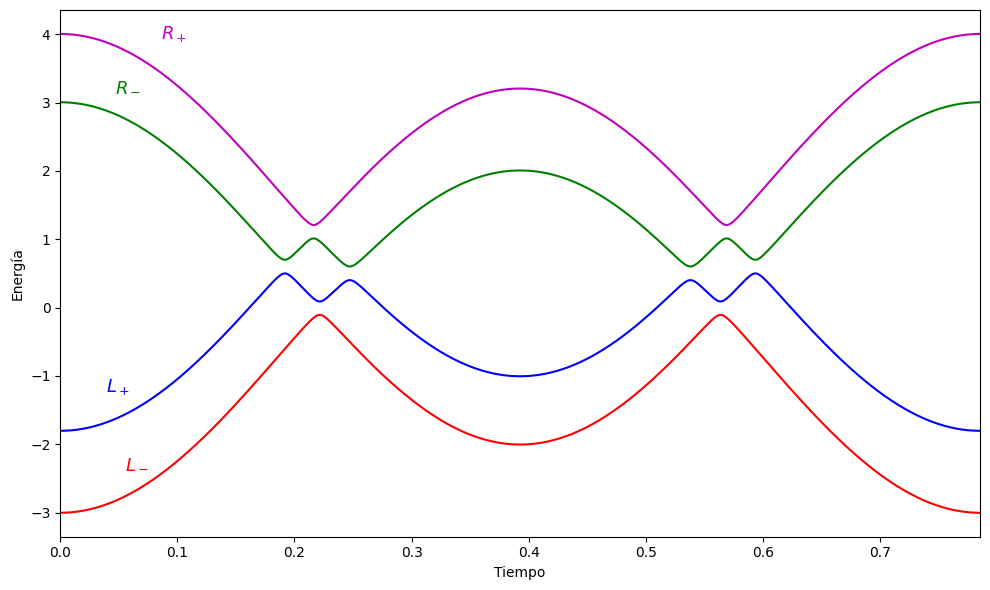

In [327]:
import os
import numpy as np
import matplotlib.pyplot as plt
from qutip import Qobj

# ===========================
# Parámetros físicos
# ===========================
hbar = 1.0
n_points = 800 # resolución temporal

# Sesgo oscilatorio
epsilon_0 = 1      # Sesgo estático 
A = 5              # Amplitud de la oscilación
omega = 8          # Frecuencia angular de la oscilación
T = 2 * np.pi / omega

# Hamiltoniano 4D
EL = 1
ER = 1.2
tc = 0.1
tpc = 0.1

def Hamiltonian(t, args):
    epsilon_0 = args['epsilon_0']
    A = args['A']
    omega = args['omega']
    EL = args['EL']
    ER = args['ER']
    tc = args['tc']
    tpc = args['tpc']
    epsilon = epsilon_0 + A * np.cos(omega * t)
    return Qobj(np.array([
        [epsilon / 2 + EL, 0, tc, tpc],
        [0, epsilon / 2, -tpc, tc],
        [tc, -tpc, -epsilon / 2 + ER, 0],
        [tpc, tc, 0, -epsilon / 2]
    ]))

# Parámetros para el Hamiltoniano
args = {'epsilon_0': epsilon_0, 'A': A, 'omega': omega, 'EL': EL, 'ER': ER, 'tc': tc, 'tpc': tpc}

# ===========================
# Rango temporal
# ===========================
t_list = np.linspace(0, T, n_points)

# ===========================
# Cálculo de energías
# ===========================
adiabatic_energies = np.zeros((4, n_points))

t_range = t_list

for i, t in enumerate(t_range):
    H_t = Hamiltonian(t, args)
    evals = H_t.eigenenergies()
    adiabatic_energies[:, i] = np.real(evals)

# ===========================
# Gráfica
# ===========================
plt.figure(figsize=(10, 6))

# Estados adiabáticos (líneas continuas)
colors = ['r', 'b', 'g', 'm']
basis_labels = ["$L_-$", "$L_+$", "$R_-$", "$R_+$"]

for i in range(4):
    plt.plot(t_range, adiabatic_energies[i], '-', color=colors[i])

label_positions = [
    [0.07 * T, adiabatic_energies[0][0] + 0.6, 'left', 'bottom'],  # L_-
    [0.05 * T, adiabatic_energies[1][0] + 0.5, 'left', 'bottom'],  # L_+
    [0.06 * T, adiabatic_energies[2][0] + 0.1, 'left', 'bottom'],  # R_-
    [0.11 * T, adiabatic_energies[3][0]-0.15, 'left', 'bottom']   # R_+
]

# Añadir etiquetas con posiciones personalizadas
for i in range(4):
    x, y, ha, va = label_positions[i]
    plt.text(x, y, basis_labels[i], va=va, ha=ha, fontsize=13, color=colors[i])

# Gráficos
plt.xlabel(r"Tiempo")
plt.ylabel("Energía")
plt.xlim(t_range[0], t_range[-1])  # Mantener límites originales
plt.tight_layout()

# Guardar imagen
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "Energias_4D_oscilatorio.pdf")
plt.savefig(desktop_path, format='pdf')
plt.show()

Se puede ver que el sistema ahora presenta cuatro cruces evitados en el sego líneal, que se traducen en ocho en el sesgo oscilatorio. De modo que en este caso se ha complicado exponencialmetne la complejidad del sistema.

Para analizar el sistema entonces realizaremos diagramas LZSM para comprender su comportamiento ante diferentes dinámicas. En primer lugar realizaremos diagramás de interferencia LZSM en el régimen diabático.

Considerando dos casos:
- Transciones con cambio orbital
- Transiciones de valle únicamente

Calculando interferencia LZSM: 100%|██████████| 160000/160000 [09:43<00:00, 274.22it/s]


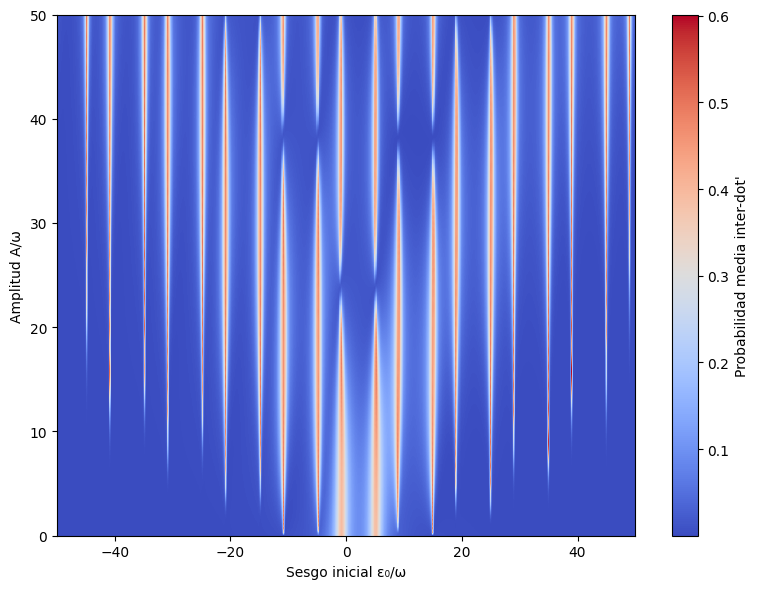

In [419]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from tqdm import tqdm
from multiprocess import Pool

# Parámetros físicos globales
omega = 10
T = 2 * np.pi / omega
n_periods = 500

# Hamiltoniano dependiente del tiempo
def Hamiltonian(t, args):
    epsilon_0, A = args['epsilon_0'], args['A']
    epsilon = epsilon_0 + A * np.cos(omega * t)
    EL, ER, tc, tpc = 1, 6, 0.5, 0.5

    H = Qobj(np.array([
        [epsilon / 2 + EL, 0, tc, tpc],
        [0, epsilon / 2, -tpc, tc],
        [tc, -tpc, -epsilon / 2 + ER, 0],
        [tpc, tc, 0, -epsilon / 2]
    ]))
    return H

# Función para calcular la probabilidad media de transición independiente para R y R'
def calculate_P_mean(params):
    i, A, j, epsilon_0, t_values_period, psi0 = params
    args = {"epsilon_0": epsilon_0, "A": A}

    U_list = propagator(Hamiltonian, t_values_period, [], args=args)
    U_T = U_list[-1]

    psi_t = psi0
    P_Lp = np.zeros(n_periods)

    for k in range(n_periods):
        psi_t = U_T * psi_t
        psi_array = psi_t.full()

        # Probabilidades lado derecho (R y R')
        P_Lp[k] = np.abs(psi_array[3, 0])**2 + np.abs(psi_array[2, 0])**2

    # Promediar independientemente y luego sumar
    P_mean_total = np.mean(P_Lp)

    return i, j, P_mean_total

# Parámetros para la simulación
epsilon_0_values = np.linspace(-50*omega, 50*omega, 400)/omega
A_values = np.linspace(0*omega, 50*omega, 400)/omega
t_values_period = np.linspace(0, T, 1000)

# Estado inicial L (base diabática)
psi0 = basis(4, 0)

# Matriz de resultados
P_mean_matrix = np.zeros((len(A_values), len(epsilon_0_values)))

# Parámetros para paralelización
params = [(i, A, j, epsilon_0, t_values_period, psi0)
          for i, A in enumerate(A_values)
          for j, epsilon_0 in enumerate(epsilon_0_values)]

# Cálculo paralelo
with Pool() as pool:
    results = list(tqdm(pool.imap(calculate_P_mean, params),
                        total=len(params),
                        desc="Calculando interferencia LZSM"))

# Rellenar matriz con resultados
for i, j, p_mean in results:
    P_mean_matrix[i, j] = p_mean

# Crear mapa de calor
plt.figure(figsize=(8, 6))
plt.imshow(P_mean_matrix, extent=[epsilon_0_values[0], epsilon_0_values[-1],
                                  A_values[0], A_values[-1]],
           origin="lower", aspect="auto", cmap="coolwarm")
plt.colorbar(label="Probabilidad media inter-dot'")
plt.xlabel("Sesgo inicial ε₀/ω")
plt.ylabel("Amplitud A/ω")
plt.tight_layout()

# Guardar imagen
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "Diagrama_4D_diabático_interdot.pdf")
plt.savefig(desktop_path, format='pdf')
plt.show()

Calculando interferencia LZSM: 100%|██████████| 40000/40000 [00:58<00:00, 683.05it/s]


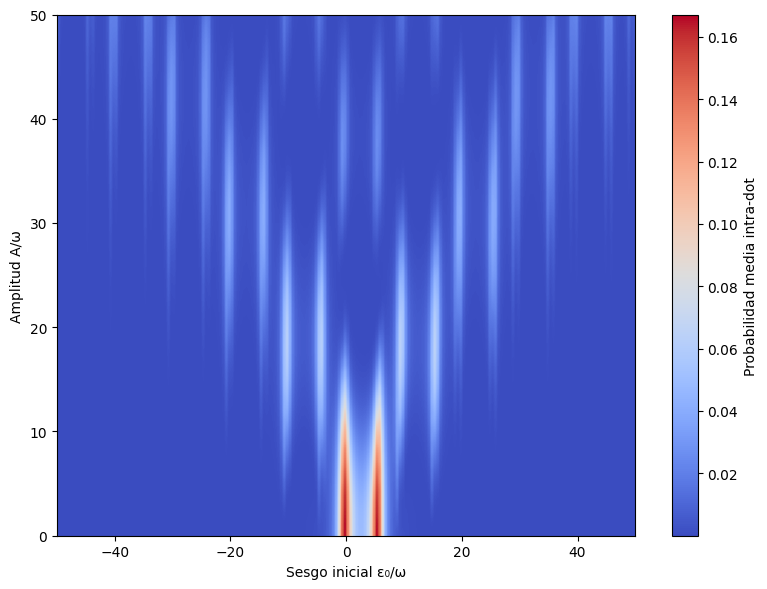

In [348]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from tqdm import tqdm
from multiprocess import Pool

# Parámetros físicos globales
omega = 10
T = 2 * np.pi / omega
n_periods = 200

# Hamiltoniano dependiente del tiempo
def Hamiltonian(t, args):
    epsilon_0, A = args['epsilon_0'], args['A']
    epsilon = epsilon_0 + A * np.cos(omega * t)
    EL, ER, tc, tpc = 1, 6, 0.5, 0.5

    H = Qobj(np.array([
        [epsilon / 2 + EL, 0, tc, tpc],
        [0, epsilon / 2, -tpc, tc],
        [tc, -tpc, -epsilon / 2 + ER, 0],
        [tpc, tc, 0, -epsilon / 2]
    ]))
    return H

# Función para calcular la probabilidad media de transición independiente para R y R'
def calculate_P_mean(params):
    i, A, j, epsilon_0, t_values_period, psi0 = params
    args = {"epsilon_0": epsilon_0, "A": A}

    U_list = propagator(Hamiltonian, t_values_period, [], args=args)
    U_T = U_list[-1]

    psi_t = psi0
    P_Lp = np.zeros(n_periods)

    for k in range(n_periods):
        psi_t = U_T * psi_t
        psi_array = psi_t.full()

        # Probabilidades lado derecho (R y R')
        P_Lp[k] = np.abs(psi_array[1, 0])**2

    # Promediar independientemente y luego sumar
    P_mean_total = np.mean(P_Lp)

    return i, j, P_mean_total

# Parámetros para la simulación
epsilon_0_values = np.linspace(-50*omega, 50*omega, 200)/omega
A_values = np.linspace(0*omega, 50*omega, 200)/omega
t_values_period = np.linspace(0, T, 500)

# Estado inicial L (base diabática)
psi0 = basis(4, 0)

# Matriz de resultados
P_mean_matrix = np.zeros((len(A_values), len(epsilon_0_values)))

# Parámetros para paralelización
params = [(i, A, j, epsilon_0, t_values_period, psi0)
          for i, A in enumerate(A_values)
          for j, epsilon_0 in enumerate(epsilon_0_values)]

# Cálculo paralelo
with Pool() as pool:
    results = list(tqdm(pool.imap(calculate_P_mean, params),
                        total=len(params),
                        desc="Calculando interferencia LZSM"))

# Rellenar matriz con resultados
for i, j, p_mean in results:
    P_mean_matrix[i, j] = p_mean

# Crear mapa de calor
plt.figure(figsize=(8, 6))
plt.imshow(P_mean_matrix, extent=[epsilon_0_values[0], epsilon_0_values[-1],
                                  A_values[0], A_values[-1]],
           origin="lower", aspect="auto", cmap="coolwarm")
plt.colorbar(label="Probabilidad media intra-dot")
plt.xlabel("Sesgo inicial ε₀/ω")
plt.ylabel("Amplitud A/ω")
plt.tight_layout()

# Guardar imagen
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "Diagrama_4D_diabático_intradot.pdf")
plt.savefig(desktop_path, format='pdf')
plt.show()

Se observan diagramas similares, en cuanto a la posición de las franjas de interferencia. Esto coincide con lo predicho en los cálculos análiticos de las condiciones de resonancia.

Con esto hemos podido caracterizar como se comporta el sistema antes los parámetros de energía locales y el sesgo oscilatorio. Falta comprender como varía el sistema frente al tunelamiento, para ello se utiliza el ángulo entre ambos tunelamientos (vease fórmula 5.9).

Calculando interferencia LZSM: 100%|██████████| 160000/160000 [07:39<00:00, 348.29it/s]


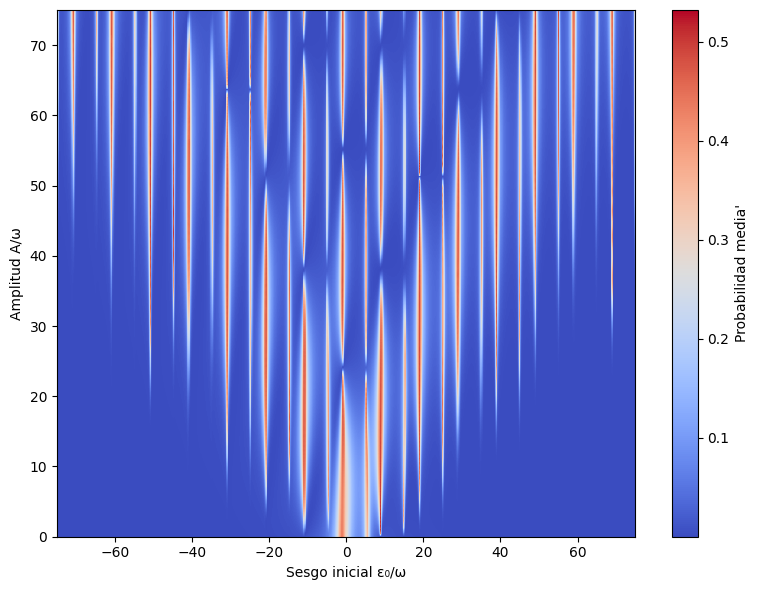

In [432]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from tqdm import tqdm
from multiprocess import Pool

# Parámetros físicos globales
omega = 10
T = 2 * np.pi / omega
n_periods = 500
tau = 0.8
theta = np.deg2rad(70)

# Hamiltoniano dependiente del tiempo
def Hamiltonian(t, args):
    epsilon_0, A = args['epsilon_0'], args['A']
    epsilon = epsilon_0 + A * np.cos(omega * t)
    EL, ER, tc, tpc = 1, 6, tau*np.cos(theta), tau*np.sin(theta)

    H = Qobj(np.array([
        [epsilon / 2 + EL, 0, tc, tpc],
        [0, epsilon / 2, -tpc, tc],
        [tc, -tpc, -epsilon / 2 + ER, 0],
        [tpc, tc, 0, -epsilon / 2]
    ]))
    return H

# Función para calcular la probabilidad media de transición independiente para R y R'
def calculate_P_mean(params):
    i, A, j, epsilon_0, t_values_period, psi0 = params
    args = {"epsilon_0": epsilon_0, "A": A}

    U_list = propagator(Hamiltonian, t_values_period, [], args=args)
    U_T = U_list[-1]

    psi_t = psi0
    P_Lp = np.zeros(n_periods)

    for k in range(n_periods):
        psi_t = U_T * psi_t
        psi_array = psi_t.full()

        # Probabilidades lado derecho (R y R')
        P_Lp[k] = np.abs(psi_array[3, 0])**2 + np.abs(psi_array[2, 0])**2

    # Promediar independientemente y luego sumar
    P_mean_total = np.mean(P_Lp)

    return i, j, P_mean_total

# Parámetros para la simulación
epsilon_0_values = np.linspace(-75*omega, 75*omega, 400)/omega
A_values = np.linspace(0*omega, 75*omega, 400)/omega
t_values_period = np.linspace(0, T, 1000)

# Estado inicial L (base diabática)
psi0 = basis(4, 0)

# Matriz de resultados
P_mean_matrix = np.zeros((len(A_values), len(epsilon_0_values)))

# Parámetros para paralelización
params = [(i, A, j, epsilon_0, t_values_period, psi0)
          for i, A in enumerate(A_values)
          for j, epsilon_0 in enumerate(epsilon_0_values)]

# Cálculo paralelo
with Pool() as pool:
    results = list(tqdm(pool.imap(calculate_P_mean, params),
                        total=len(params),
                        desc="Calculando interferencia LZSM"))

# Rellenar matriz con resultados
for i, j, p_mean in results:
    P_mean_matrix[i, j] = p_mean

# Crear mapa de calor
plt.figure(figsize=(8, 6))
plt.imshow(P_mean_matrix, extent=[epsilon_0_values[0], epsilon_0_values[-1],
                                  A_values[0], A_values[-1]],
           origin="lower", aspect="auto", cmap="coolwarm")
plt.colorbar(label="Probabilidad media'")
plt.xlabel("Sesgo inicial ε₀/ω")
plt.ylabel("Amplitud A/ω")
plt.tight_layout()

# Guardar imagen
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "Diagrama_4D_diabático_interdot_t_1.pdf")
plt.savefig(desktop_path, format='pdf')
plt.show()

Calculando interferencia LZSM: 100%|██████████| 160000/160000 [07:53<00:00, 337.64it/s]


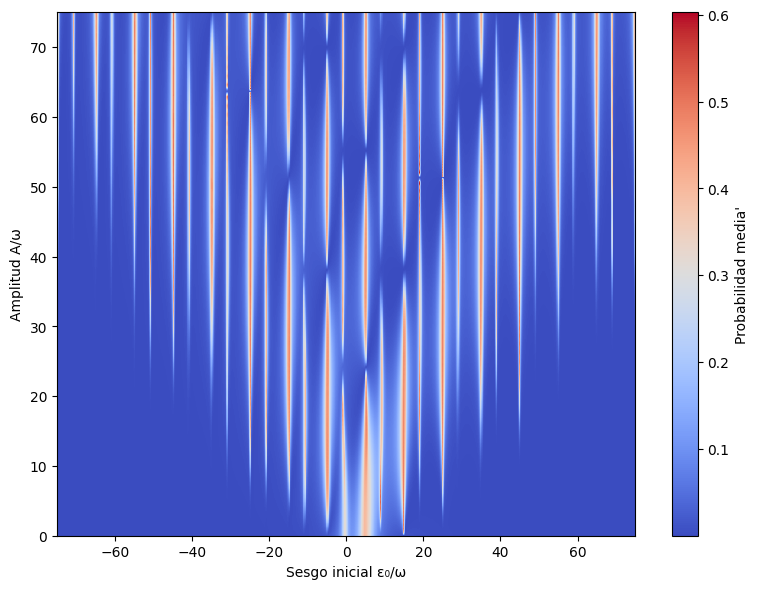

In [433]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from tqdm import tqdm
from multiprocess import Pool

# Parámetros físicos globales
omega = 10
T = 2 * np.pi / omega
n_periods = 500
tau = 0.8
theta = np.deg2rad(20)

# Hamiltoniano dependiente del tiempo
def Hamiltonian(t, args):
    epsilon_0, A = args['epsilon_0'], args['A']
    epsilon = epsilon_0 + A * np.cos(omega * t)
    EL, ER, tc, tpc = 1, 6, tau*np.cos(theta), tau*np.sin(theta)

    H = Qobj(np.array([
        [epsilon / 2 + EL, 0, tc, tpc],
        [0, epsilon / 2, -tpc, tc],
        [tc, -tpc, -epsilon / 2 + ER, 0],
        [tpc, tc, 0, -epsilon / 2]
    ]))
    return H

# Función para calcular la probabilidad media de transición independiente para R y R'
def calculate_P_mean(params):
    i, A, j, epsilon_0, t_values_period, psi0 = params
    args = {"epsilon_0": epsilon_0, "A": A}

    U_list = propagator(Hamiltonian, t_values_period, [], args=args)
    U_T = U_list[-1]

    psi_t = psi0
    P_Lp = np.zeros(n_periods)

    for k in range(n_periods):
        psi_t = U_T * psi_t
        psi_array = psi_t.full()

        # Probabilidades lado derecho (R y R')
        P_Lp[k] = np.abs(psi_array[3, 0])**2 + np.abs(psi_array[2, 0])**2

    # Promediar independientemente y luego sumar
    P_mean_total = np.mean(P_Lp)

    return i, j, P_mean_total

# Parámetros para la simulación
epsilon_0_values = np.linspace(-75*omega, 75*omega, 400)/omega
A_values = np.linspace(0*omega, 75*omega, 400)/omega
t_values_period = np.linspace(0, T, 1000)

# Estado inicial L (base diabática)
psi0 = basis(4, 0)

# Matriz de resultados
P_mean_matrix = np.zeros((len(A_values), len(epsilon_0_values)))

# Parámetros para paralelización
params = [(i, A, j, epsilon_0, t_values_period, psi0)
          for i, A in enumerate(A_values)
          for j, epsilon_0 in enumerate(epsilon_0_values)]

# Cálculo paralelo
with Pool() as pool:
    results = list(tqdm(pool.imap(calculate_P_mean, params),
                        total=len(params),
                        desc="Calculando interferencia LZSM"))

# Rellenar matriz con resultados
for i, j, p_mean in results:
    P_mean_matrix[i, j] = p_mean

# Crear mapa de calor
plt.figure(figsize=(8, 6))
plt.imshow(P_mean_matrix, extent=[epsilon_0_values[0], epsilon_0_values[-1],
                                  A_values[0], A_values[-1]],
           origin="lower", aspect="auto", cmap="coolwarm")
plt.colorbar(label="Probabilidad media'")
plt.xlabel("Sesgo inicial ε₀/ω")
plt.ylabel("Amplitud A/ω")
plt.tight_layout()

# Guardar imagen
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "Diagrama_4D_diabático_interdot_t_2.pdf")
plt.savefig(desktop_path, format='pdf')
plt.show()

Podemos ver que el control del angulo de tunelamiento permite disminuir o aumentar las franjas de interferencia, esto hace que sea posible controlar estos canales de forma experimental.

Finalmente, estudiamos el caso adiabático.

/opt/anaconda3/lib/python3.11/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
Simulando proyección en estado adiabático: 100%|██████████| 250000/250000 [1:44:50<00:00, 39.74it/s]  


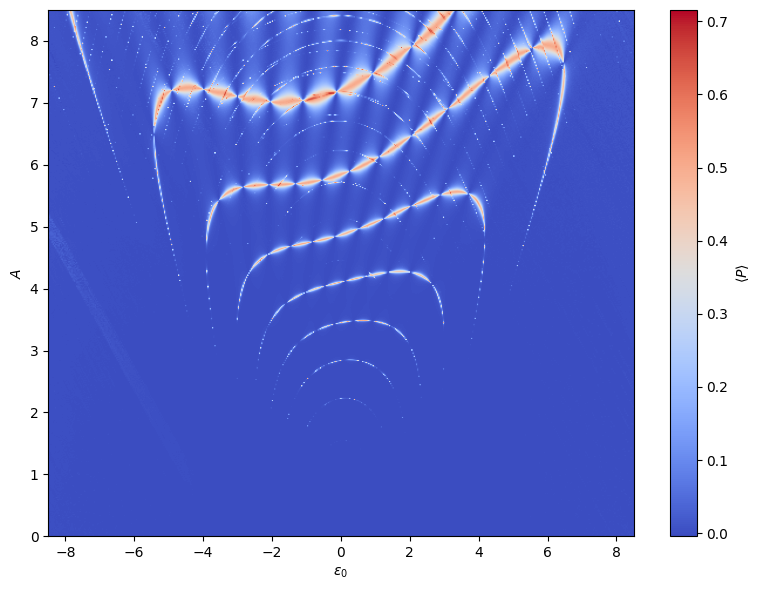

In [397]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from tqdm import tqdm
from multiprocess import Pool
from qutip.solver import Options

# ===========================
# Unidades y parámetros físicos
# ===========================

omega = 0.2 # frecuencia de modulación
T = 2 * np.pi / omega  # periodo asociado
n_periods = 1000  # número de periodos para la evolución temporal

target_index = 0 #Estado al cual proyectamos

# ===========================
# Configuración del solver
# ===========================

options = Options(store_states=True, nsteps=10000)

# ===========================
# Hamiltoniano dependiente del tiempo
# ===========================

def Hamiltonian(t, args):
    epsilon_0, A = args['epsilon_0'], args['A']
    epsilon = epsilon_0 + A * np.cos(omega * t)
    EL, ER, tc, tpc = 4.5, 4, 1, 1  # parámetros de energía locales y acoplos

    H = Qobj(np.array([
        [epsilon / 2 + EL, 0, tc, tpc],
        [0, epsilon / 2, -tpc, tc],
        [tc, -tpc, -epsilon / 2 + ER, 0],
        [tpc, tc, 0, -epsilon / 2]
    ]))
    return H

# ===========================
# Evolución estroboscópica y proyección sobre el estado adiabático deseado
# ===========================

def calculate_ground_state_overlap(params):
    i, A, j, epsilon_0 = params
    args = {"epsilon_0": epsilon_0, "A": A}

    # Estado inicial: adiabático en t = 0 con índice target_index
    H0 = Hamiltonian(0, args)
    _, evecs = H0.eigenstates()
    psi0 = evecs[target_index]

    # Evolución estroboscópica usando propagadores
    t_values_period = np.linspace(0, T, 3000)
    U_list = propagator(Hamiltonian, t_values_period, [], args=args)
    U_T = U_list[-1]

    psi_t = psi0
    overlaps = np.zeros(n_periods)
    for k in range(n_periods):
        t_k = 0  # Evaluamos siempre en t = 0 ya que usamos evolución estroboscópica
        H_k = Hamiltonian(t_k, args)
        _, evecs_t = H_k.eigenstates()
        target_state_t = evecs_t[target_index]
        overlaps[k] = abs(target_state_t.dag() * psi_t)**2
        psi_t = U_T * psi_t  # Evolución un periodo

    mean_overlap = np.mean(overlaps)
    return i, j, mean_overlap

# ===========================
# Barrido de parámetros
# ===========================

epsilon_0_values = np.linspace(-8.5, 8.5, 500)  # μeV
A_values = np.linspace(0, 8.5, 500)            # μeV
params = [(i, A, j, epsilon_0)
          for i, A in enumerate(A_values)
          for j, epsilon_0 in enumerate(epsilon_0_values)]

# ===========================
# Cálculo paralelo
# ===========================

overlap_matrix = np.zeros((len(A_values), len(epsilon_0_values)))
with Pool(processes=6) as pool:
    results = list(tqdm(pool.imap(calculate_ground_state_overlap, params),
                        total=len(params),
                        desc="Simulando proyección en estado adiabático"))

for i, j, mean_overlap in results:
    overlap_matrix[i, j] = mean_overlap

# ===========================
# Gráfica del patrón de interferencia
# ===========================

plt.figure(figsize=(8, 6))
plt.imshow(1 - overlap_matrix, extent=[epsilon_0_values[0], epsilon_0_values[-1],
                                       A_values[0], A_values[-1]],
           origin="lower", aspect="auto", cmap="coolwarm")
plt.colorbar(label=r"$\langle P \rangle$")
plt.xlabel(r"$\epsilon_0$")
plt.ylabel(r"$A$")
plt.tight_layout()

# Guardar imagen
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "Diagrama_4D_adiabático.pdf")
plt.savefig(desktop_path, format='pdf')
plt.show()

En este régimen observamos dos peculiaridades:
- A bajas modulaciones hay un diagrama similar al de dos niveles (permite uso de AIM y 'dressing'
- A altas modulaciones el patrón presenta una asimetría debida a la asímetria en los valles locales.